<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/training_data_processing_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing for Landuse Classification

In this lesson, we will use a sub-set of Landsat 9 satellite megapixel-based in the central part of the country.  We will prepare them for pixel-based classification using machine learning algorithms. The images were already radiometrically and atmospherically corrected.

We will train the machine learning models with four feature classes extracted from Google Earth imagery: (1) Home stage vegetation, (2) cropland, (3) Bare soil/Developed, and (4) water bodies. We used on-screen digitization in ArcMap to Create polygons representing members of these feature classes. First, we will convert the polygons to a 30 x 30-meter raster grid and then to a spatial points data frame. Next, we will extract values from the B2, B3, B4, B5, B6, and B7 bands and 30 m SRTM DEM and add them to the spatial point data frame we will use for training, validation, and testing the models. We will also use all these bands and DEM to create a prediction grid point data set for predicting land-use classes.

### Install rpy2

In [1]:

!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314920 sha256=cb3db3562b92286b8548b3a5b0336aa689a0c0977228b3b23487f46be1a46bef
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Package

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
remotes::install_github("rstudio/tensorflow", lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages("keras",lib='drive/My Drive/R/' )

### Install R-packages

In [ ]:
%%R
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(sf)
library(raster)
library(rgdal)
library(tidyverse)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)

### Data

In [ ]:
%%R
bd<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi_01<-st_read("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp")
aoi_02<-st_read("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/AOI_2.shp")
ls<-rast("/content/drive/MyDrive/Data/DSM_AOI/Landsat/Level_01/Scene/LC08_L1TP_137044_20230203_20230209_02_T1/LC08_L1TP_137044_20230203_20230209_02_T1_B1.TIF")

Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `AOI_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 150901.7 ymin: 2558579 xmax: 180901.7 ymax: 2588579
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading lay

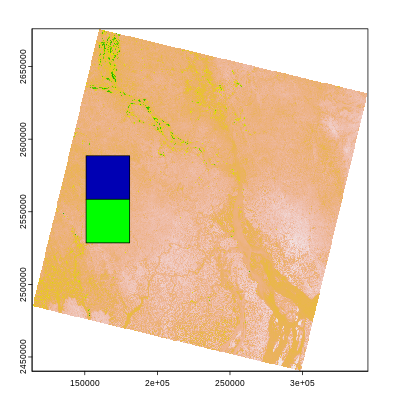

In [ ]:
%%R -w 400 -h 400 -u px
#plot(bd, main= "Landsat 8 Scene: 137/44 and AOI")
plot(ls, legend =F)
plot(aoi_01, add=TRUE)
plot(aoi_02, add=TRUE, col="green")

### Import Raster Images

In [4]:
%%R
# AOI-1
multi_01<-raster::stack("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/multiband_2_7_aoi_1.tif")
dem_01<-raster::raster('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/dem_aoi_1.tif')
names(dem_01)<-"dem"

In [5]:
%%R
# AOI-2
multi_02<-raster::stack("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/multiband_2_7_aoi_2.tif")
dem_02<-raster::raster('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/dem_aoi_2.tif')
names(dem_02)<-"dem"

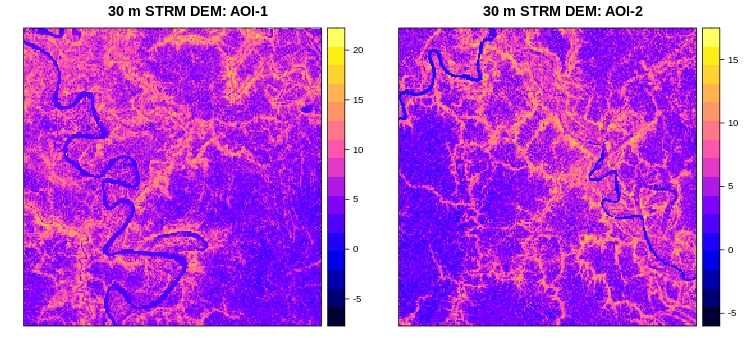

In [ ]:
%%R -w 750 -h 350 -u px
p1 = spplot(dem_01, main="30 m STRM DEM: AOI-1")
p2 = spplot(dem_02, main="30 m STRM DEM: AOI-2")
grid.arrange(p1, p2, ncol=2)

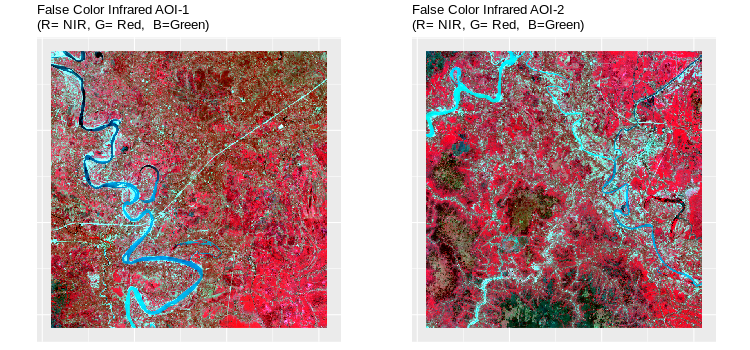

In [ ]:
%%R -w 750 -h 350 -u px
# False Color image
p3=ggRGB(multi_01, r=4, g=3, b=2, stretch = "lin")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
  ggtitle("False Color Infrared AOI-1\n(R= NIR, G= Red,  B=Green)")

p4=ggRGB(multi_02, r=4, g=3, b=2, stretch = "lin")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
  ggtitle("False Color Infrared AOI-2\n(R= NIR, G= Red,  B=Green)")

grid.arrange(p3, p4, ncol=2)

## Training Data Processing

### Convert training polygon to raster

Before converting the land use polygon file to raster, we will extract the extent of any band of Landsat 9 to set the raster extent. We use B2 to define raster extent.

In [ ]:
%%R
poly_01 <- st_read('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp')
poly_01

Reading layer `train_poly_aoi_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp' 
  using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 208 features and 1 field (with 3 geometries empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151009 ymin: 2558707 xmax: 180431.2 ymax: 2588351
Projected CRS: WGS 84 / UTM zone 46N + unknown
Simple feature collection with 208 features and 1 field (with 3 geometries empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151009 ymin: 2558707 xmax: 180431.2 ymax: 2588351
Projected CRS: WGS 84 / UTM zone 46N + unknown
First 10 features:
   Id                       geometry
1   0 POLYGON ((167583.4 2575164,...
2   0 POLYGON ((165182.3 2573127,...
3   0 POLYGON ((164196.7 2575210,...
4   0 POLYGON ((162682 2571758, 1...
5   0 POLYGON ((160896.9 2584646,...
6   0 POLYGON ((161885.7 2584652,

In [ ]:
%%R
extent_01<-ext(multi_01[[2]])


In [ ]:
%%R
# create an empty raster
r_01 <- rast(extent_01, resolution = 10)
rp_01 <- rasterize(poly_01, r_01, 'Id')


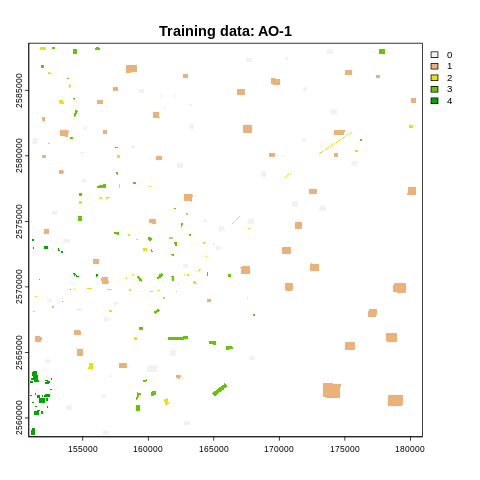

In [ ]:
%%R
plot(rp_01, main="Training data: AO-1")

### Convert to Spatial Point dataframe

In [ ]:
%%R
rp.df_01 <- as.data.frame(rp_01, xy = TRUE) %>%
      dplyr::rename("Class_ID" = Id)
head(rp.df_01)

           x       y Class_ID
72250 152660 2588350        3
75253 152660 2588340        3
75254 152670 2588340        3
75255 152680 2588340        3
75256 152690 2588340        3
75257 152700 2588340        3


In [ ]:
%%R
xy_01 <- rp.df_01[,c(1,2)]
point.SPDF_01<- SpatialPointsDataFrame(coords = xy_01,
                                data=rp.df_01,
                                proj4string = CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs"))

### Extract bands  and dem values to training points

In [ ]:
%%R
point.bands_01 <- raster::extract(multi_01, point.SPDF_01)
point.dem_01 <- raster::extract(dem_01, point.SPDF_01)
point.mf_01<-cbind(rp.df_01,point.bands_01, point.dem_01)
colnames(point.mf_01)[10]<-"dem"
glimpse(point.mf_01)

Rows: 245,459
Columns: 10
$ x        <dbl> 152660, 152660, 152670, 152680, 152690, 152700, 152710, 15272…
$ y        <dbl> 2588350, 2588340, 2588340, 2588340, 2588340, 2588340, 2588340…
$ Class_ID <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ B2       <dbl> 9169, 9169, 9169, 9169, 9119, 9119, 9119, 9108, 9108, 9108, 9…
$ B3       <dbl> 10301, 10301, 10301, 10301, 10279, 10279, 10279, 10298, 10298…
$ B4       <dbl> 9516, 9516, 9516, 9516, 9490, 9490, 9490, 9545, 9545, 9545, 9…
$ B5       <dbl> 9919, 9919, 9919, 9919, 9919, 9919, 9919, 9939, 9939, 9939, 9…
$ B6       <dbl> 8417, 8417, 8417, 8417, 8409, 8409, 8409, 8418, 8418, 8418, 8…
$ B7       <dbl> 7970, 7970, 7970, 7970, 7962, 7962, 7962, 7963, 7963, 7963, 7…
$ dem      <dbl> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…


In [ ]:
%%R
point.mf_01 %>% group_by(Class_ID)  %>%
                    summarise(N = length(x))

# A tibble: 5 × 2
  Class_ID      N
     <int>  <int>
1        0  52821
2        1 128129
3        2  16365
4        3  32990
5        4  15154


### Add class ID and save as a CSV file

In [7]:
%%R
# Import lnaduse ID file
ID<-read.csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/landuse_id.csv")
ID

  Class_ID   Class           Description
1        0 Class_1 Homestead vegetation 
2        1 Class_2              Cropland
3        2 Class_3   Bare soil/Developed
4        3 Class_4            Water body
5        4 Class_5            Wet fallow


In [ ]:
%%R
# Join with point data frame
point.gt_01<-inner_join(point.mf_01, ID) %>%
  select(x,y, B2, B3, B4, B5, B6, B7, dem, Class_ID, Class, Description)
point.gt_01 %>% group_by(Description)  %>%
                    summarise(N = length(x))

Joining with `by = join_by(Class_ID)`
# A tibble: 5 × 2
  Description                  N
  <chr>                    <int>
1 "Bare soil/Developed"    16365
2 "Cropland"              128129
3 "Homestead vegetation "  52821
4 "Water body"             32990
5 "Wet fallow"             15154


In [ ]:
%%R
head(point.gt_01)

       x       y   B2    B3   B4   B5   B6   B7 dem Class_ID   Class
1 152660 2588350 9169 10301 9516 9919 8417 7970   2        3 Class_4
2 152660 2588340 9169 10301 9516 9919 8417 7970   2        3 Class_4
3 152670 2588340 9169 10301 9516 9919 8417 7970   2        3 Class_4
4 152680 2588340 9169 10301 9516 9919 8417 7970   2        3 Class_4
5 152690 2588340 9119 10279 9490 9919 8409 7962   2        3 Class_4
6 152700 2588340 9119 10279 9490 9919 8409 7962   2        3 Class_4
  Description
1  Water body
2  Water body
3  Water body
4  Water body
5  Water body
6  Water body


In [ ]:
%%R
write_csv(point.gt_01, "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data.csv")

### Test data -  AOI-2

In [8]:
%%R
poly_02 <- st_read('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/train_poly_aoi_2.shp')
extent_02<-ext(multi_02[[2]])

# create an empty raster
r_02 <- rast(extent_02, resolution = 10)
rp_02 <- rasterize(poly_02, r_02, 'Id')

# Convet to spatial point dataframe

rp.df_02 <- as.data.frame(rp_02, xy = TRUE) %>%
      dplyr::rename("Class_ID" = Id)
xy_02 <- rp.df_02[,c(1,2)]
point.SPDF_02<- SpatialPointsDataFrame(coords = xy_02,
                                data=rp.df_02,
                                proj4string = CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs"))

# Rxtract Bands and dem values

point.bands_02 <- raster::extract(multi_02, point.SPDF_02)
point.dem_02 <- raster::extract(dem_02, point.SPDF_02)
point.mf_02<-cbind(rp.df_02,point.bands_02, point.dem_02)
colnames(point.mf_02)[10]<-"dem"
glimpse(point.mf_02)

# Join with point data frame
point.gt_02<-inner_join(point.mf_02, ID) %>%
  select(x,y, B2, B3, B4, B5, B6, B7, dem, Class_ID, Class, Description)

# writr as CSV file
write_csv(point.gt_02, "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/point_data_test_aoi_2.csv")
head(point.gt_02)

Reading layer `train_poly_aoi_2' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/train_poly_aoi_2.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 26 features and 1 field
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 153419.3 ymin: 2532527 xmax: 172829.1 ymax: 2554958
Projected CRS: WGS 84 / UTM zone 46N + unknown
Rows: 42,847
Columns: 10
$ x        <dbl> 158840, 158850, 158860, 158870, 158880, 158890, 158900, 15891…
$ y        <dbl> 2554950, 2554950, 2554950, 2554950, 2554950, 2554950, 2554950…
$ Class_ID <int> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3…
$ B2       <dbl> 9523, 9523, 9523, 9492, 9492, 9492, 9558, 9558, 9558, 9580, 9…
$ B3       <dbl> 10909, 10909, 10909, 10905, 10905, 10905, 10933, 10933, 10933…
$ B4       <dbl> 10741, 10741, 10741, 10701, 10701, 10701, 10695, 10695, 10695…
$ B5       <dbl> 10114, 10114, 10114, 10037, 10037, 10037, 9947, 9947, 9947, 9…
$ B

In [ ]:
%%R
point.gt_02 %>% group_by(Description)  %>%
                    summarise(N = length(x))

# A tibble: 5 × 2
  Description                 N
  <chr>                   <int>
1 "Bare soil/Developed"    5722
2 "Cropland"               6284
3 "Homestead vegetation "  5880
4 "Water body"             3337
5 "Wet fallow"            21624


## Grid Data Processing

First, we will empty point data frame, will use Band B2

In [ ]:
%%R
multi_01

class      : RasterStack 
dimensions : 1001, 1001, 1002001, 6  (nrow, ncol, ncell, nlayers)
resolution : 30, 30  (x, y)
extent     : 150885, 180915, 2558565, 2588595  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=46 +datum=WGS84 +units=m +no_defs 
names      :    B2,    B3,    B4,    B5,    B6,    B7 
min values :  7418,  8493,  7597,  8822,  7904,  7622 
max values : 14226, 16173, 17473, 24870, 26354, 24278 



In [ ]:
%%R
grid.point_01 <- data.frame(rasterToPoints(multi_01[[1]]))
# Remove B2 column, just keep x & y
grid.point_01$B2<-NULL
# define co-ordinates and projection
coordinates(grid.point_01) <- ~x + y
projection(grid.point_01) <- CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs")

In [ ]:
%%R
grid.point_02 <- data.frame(rasterToPoints(multi_02[[1]]))
# Remove B2 column, just keep x & y
grid.point_02$B2<-NULL
# define co-ordinates and projection
coordinates(grid.point_02) <- ~x + y
projection(grid.point_02) <- CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs")

### Extract all bands and dem values to grird locations

In [ ]:
%%R
bands.grid_01<- raster::extract(multi_01, grid.point_01, df=TRUE, method='simple')
dem.grid_01<- raster::extract(dem_01, grid.point_01, df=TRUE, method='simple')
grid_01<-cbind(as.data.frame(grid.point_01),bands.grid_01, dem.grid_01)
grid_01[,10]<-NULL
write_csv(grid_01,"/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_01.csv" )
head(grid_01)

In [ ]:
%%R
bands.grid_02<- raster::extract(multi_02, grid.point_02, df=TRUE, method='simple')
dem.grid_02<- raster::extract(dem_02, grid.point_02, df=TRUE, method='simple')
grid_02<-cbind(as.data.frame(grid.point_02),bands.grid_02, dem.grid_02)
grid_02[,10]<-NULL
write_csv(grid_02,"/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_02.csv" )
head(grid_02)

       x       y ID   B2    B3   B4    B5   B6   B7      dem
1 150930 2558550  1 8459 10037 9552 10785 8723 8083 4.824776
2 150960 2558550  2 8440  9984 9508 10670 8742 8139 5.421584
3 150990 2558550  3 8405  9943 9478 10395 8476 7983 4.683115
4 151020 2558550  4 8453  9972 9517 11683 9858 8874 4.545923
5 151050 2558550  5 8461 10052 9515 11521 9530 8642 5.788843
6 151080 2558550  6 8424 10075 9507 10427 8649 8078 6.390258


### Further Reading

1.  [R - using Random Forests, Support Vector Machines, and Neural Networks for a pixel-based supervised classification of Sentinel-2 multispectral images](https://valentinitnelav.github.io/satellite-image-classification-r/)